In [45]:
"""
small change of def train_transformer() in seq2seq.py and rename into seq2seq__utils.py:
def train_transformer(model, train_loader, optimizer, epochs=3, device='cpu'):
    model = model.to(device)
    history = []

    for epoch in range(epochs):
        model.train()
        total_loss = 0.0

        for batch in train_loader:
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            loss = outputs.loss

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_loss = total_loss / max(1, len(train_loader))
        history.append(avg_loss)
        print(f'Epoch {epoch + 1}/{epochs}, Loss: {avg_loss:.4f}')

    return {'train_loss': history}
"""

"\nsmall change of def train_transformer() in seq2seq.py and rename into seq2seq__utils.py\ndef train_transformer(model, train_loader, optimizer, epochs=3, device='cpu'):\n    model = model.to(device)\n    history = []\n\n    for epoch in range(epochs):\n        model.train()\n        total_loss = 0.0\n\n        for batch in train_loader:\n            batch = {k: v.to(device) for k, v in batch.items()}\n            outputs = model(**batch)\n            loss = outputs.loss\n\n            optimizer.zero_grad()\n            loss.backward()\n            optimizer.step()\n\n            total_loss += loss.item()\n\n        avg_loss = total_loss / max(1, len(train_loader))\n        history.append(avg_loss)\n        print(f'Epoch {epoch + 1}/{epochs}, Loss: {avg_loss:.4f}')\n\n    return {'train_loss': history}\n"

In [44]:
!pip install evaluate
!pip install bert_score

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch
from torch.optim import AdamW
from torch.utils.data import DataLoader
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, DataCollatorForSeq2Seq
from evaluate import load
from seq2seq__utils import create_transformers_train_data, decode_with_transformer, train_transformer

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [5]:
data = pd.read_csv('../../data/yelp/test_en_parallel.txt', sep='\t', header=None)
data = data[[0, 1]]
data.columns = ['NEG', 'POS']

print(f"Total pairs: {len(data)}")
data.head()

Total pairs: 1001


,NEG,POS
0,Style 1,Style 2
1,ever since joes has changed hands it's just go...,Ever since joes has changed hands it's gotten ...
2,there is definitely not enough room in that pa...,There is so much room in that part of the venue
3,so basically tasted watered down.,It didn't taste watered down at all.
4,she said she'd be back and disappeared for a f...,"She said she'd be back, and didn't disappear a..."


In [6]:
neg_sentences = data['NEG'].values
pos_sentences = data['POS'].values

X_train, X_temp, y_train, y_temp = train_test_split(
    neg_sentences, pos_sentences, test_size=0.2, random_state=42
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42
)

print(f"Train pairs: {len(X_train)}")
print(f"Validation pairs: {len(X_val)}")
print(f"Test pairs: {len(X_test)}")

Train pairs: 800
Validation pairs: 100
Test pairs: 101


In [7]:
def evaluate_seq2seq(model, tokenizer, inputs, references, instruction=None,
                     device='cpu', max_samples=None):
    model = model.to(device)
    model.eval()

    preds = []
    refs = []

    bleu = load('bleu')
    bertscore = load('bertscore')

    with torch.no_grad():
        for i, (neg, pos) in enumerate(zip(inputs, references)):
            if max_samples is not None and i >= max_samples:
                break

            if instruction is not None:
                src = f"{instruction}{neg}"
            else:
                src = neg

            pred = decode_with_transformer(src, tokenizer, model, device=device)
            preds.append(pred)
            refs.append(pos)

    bleu_score = bleu.compute(predictions=preds, references=refs)['bleu']

    bert = bertscore.compute(
        predictions=preds,
        references=refs,
        model_type='microsoft/deberta-xlarge-mnli'
    )
    bert_f1 = float(np.mean(bert['f1']))

    return bleu_score, bert_f1, preds, refs

In [8]:
configs_t5 = [
    {'name': 'higher_lr', 'lr': 0.001,  'epochs': 3, 'batch_size': 64},
    {'name': 'medium_lr', 'lr': 0.0005,  'epochs': 3, 'batch_size': 64},
    {'name': 'low_lr_more_epochs', 'lr': 0.00002,  'epochs': 5, 'batch_size': 64},
]

In [9]:
model_name_t5 = "t5-small"

tokenizer_t5 = AutoTokenizer.from_pretrained(model_name_t5)
_ = AutoModelForSeq2SeqLM.from_pretrained(model_name_t5)

instruction_t5 = "Rewrite the following negative review as a positive one: "

train_inputs_t5 = [f"{instruction_t5}{s}" for s in X_train]
val_inputs_t5   = [f"{instruction_t5}{s}" for s in X_val]
test_inputs_t5  = [f"{instruction_t5}{s}" for s in X_test]

In [10]:
results_t5 = []

for cfg in configs_t5:
    print(f"\nTraining T5 with config: {cfg['name']}")

    model_t5 = AutoModelForSeq2SeqLM.from_pretrained(model_name_t5)

    train_set_t5 = create_transformers_train_data(
        train_inputs_t5,
        y_train.tolist(),
        tokenizer_t5
    )

    data_collator_t5 = DataCollatorForSeq2Seq(tokenizer=tokenizer_t5, model=model_t5)
    train_loader_t5 = DataLoader(
        train_set_t5,
        batch_size=cfg['batch_size'],
        shuffle=True,
        collate_fn=data_collator_t5
    )

    optimizer_t5 = AdamW(model_t5.parameters(), lr=cfg['lr'])

    history_t5 = train_transformer(
        model_t5,
        train_loader_t5,
        optimizer_t5,
        epochs=cfg['epochs'],
        device=device
    )

    bleu_t5, bert_f1_t5, preds_t5, refs_t5 = evaluate_seq2seq(
        model_t5,
        tokenizer_t5,
        X_test,
        y_test,
        instruction=instruction_t5,
        device=device,
        max_samples=None
    )

    print(f"Config {cfg['name']} | BLEU: {bleu_t5:.4f} | BERTScore-F1: {bert_f1_t5:.4f}")

    results_t5.append({
        'config': cfg,
        'bleu': bleu_t5,
        'bertscore_f1': bert_f1_t5,
        'history': history_t5,
        'predictions': preds_t5[:3]
    })


Training T5 with config: higher_lr


C:\FINKI\VII_semestar\NLP\code\.venv\Lib\site-packages\transformers\tokenization_utils_base.py:4034: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


Epoch 1/3, Loss: 4.4493
Epoch 2/3, Loss: 3.6867
Epoch 3/3, Loss: 3.4387
Config higher_lr | BLEU: 0.0152 | BERTScore-F1: 0.6203

Training T5 with config: medium_lr
Epoch 1/3, Loss: 4.4366
Epoch 2/3, Loss: 3.8043
Epoch 3/3, Loss: 3.6073
Config medium_lr | BLEU: 0.0212 | BERTScore-F1: 0.5184

Training T5 with config: low_lr_more_epochs
Epoch 1/5, Loss: 5.8174
Epoch 2/5, Loss: 5.3121
Epoch 3/5, Loss: 5.0051
Epoch 4/5, Loss: 4.8032
Epoch 5/5, Loss: 4.6470
Config low_lr_more_epochs | BLEU: 0.0349 | BERTScore-F1: 0.3882


In [11]:
results_t5_df = pd.DataFrame([
    {
        'Config': r['config']['name'],
        'Learning Rate': r['config']['lr'],
        'Epochs': r['config']['epochs'],
        'Batch Size': r['config']['batch_size'],
        'BLEU': f"{r['bleu']:.4f}",
        'BERTScore-F1': f"{r['bertscore_f1']:.4f}"
    }
    for r in results_t5
])

print("T5 – hyperparameter comparison:")
print(results_t5_df.to_string(index=False))

T5 – hyperparameter comparison:
            Config  Learning Rate  Epochs  Batch Size   BLEU BERTScore-F1
         higher_lr        0.00100       3          64 0.0152       0.6203
         medium_lr        0.00050       3          64 0.0212       0.5184
low_lr_more_epochs        0.00002       5          64 0.0349       0.3882


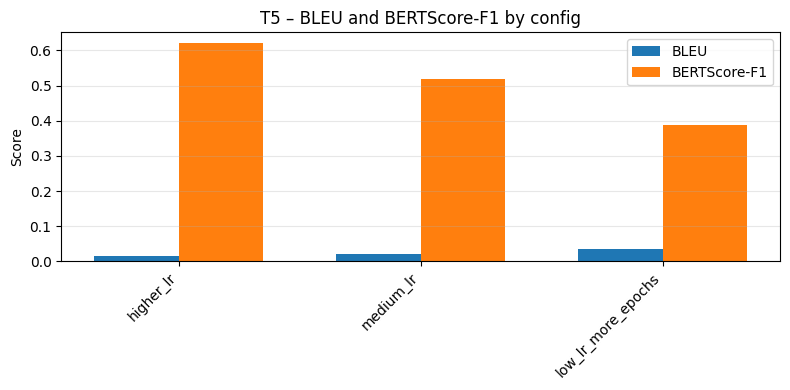

In [12]:
cfg_names_t5 = [r['config']['name'] for r in results_t5]
bleu_scores_t5 = [r['bleu'] for r in results_t5]
bert_f1_t5 = [r['bertscore_f1'] for r in results_t5]

x = np.arange(len(cfg_names_t5))
width = 0.35

plt.figure(figsize=(8, 4))
plt.bar(x - width/2, bleu_scores_t5, width, label='BLEU')
plt.bar(x + width/2, bert_f1_t5, width, label='BERTScore-F1')

plt.xticks(x, cfg_names_t5, rotation=45, ha='right')
plt.ylabel('Score')
plt.title('T5 – BLEU and BERTScore-F1 by config')
plt.grid(axis='y', alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

In [13]:
configs_flan = [
    {'name': 'higher_lr', 'lr': 0.001, 'epochs': 3, 'batch_size': 64},
    {'name': 'medium_lr', 'lr': 0.0005, 'epochs': 3, 'batch_size': 64},
    {'name': 'low_lr_more_epochs', 'lr': 0.00002, 'epochs': 5, 'batch_size': 64},
]

In [35]:
model_name_flan = "google/flan-t5-small"

tokenizer_flan = AutoTokenizer.from_pretrained(model_name_flan)
_ = AutoModelForSeq2SeqLM.from_pretrained(model_name_flan)

instruction_flan = "transform negative to positive: "

train_inputs_flan = [f"{instruction_flan}{s}" for s in X_train]
val_inputs_flan   = [f"{instruction_flan}{s}" for s in X_val]
test_inputs_flan  = [f"{instruction_flan}{s}" for s in X_test]

In [36]:
results_flan = []

for cfg in configs_flan:
    print(f"\nTraining FLAN-T5 with config: {cfg['name']}")

    model_flan = AutoModelForSeq2SeqLM.from_pretrained(model_name_flan)

    train_set_flan = create_transformers_train_data(
        train_inputs_flan,
        y_train.tolist(),
        tokenizer_flan
    )

    data_collator_flan = DataCollatorForSeq2Seq(tokenizer=tokenizer_flan, model=model_flan)
    train_loader_flan = DataLoader(
        train_set_flan,
        batch_size=cfg['batch_size'],
        shuffle=True,
        collate_fn=data_collator_flan
    )

    optimizer_flan = AdamW(model_flan.parameters(), lr=cfg['lr'])

    history_flan = train_transformer(
        model_flan,
        train_loader_flan,
        optimizer_flan,
        epochs=cfg['epochs'],
        device=device
    )

    bleu_flan, bert_f1_flan, preds_flan, refs_flan = evaluate_seq2seq(
        model_flan,
        tokenizer_flan,
        X_test,
        y_test,
        instruction=instruction_flan,
        device=device,
        max_samples=None
    )

    print(f"Config {cfg['name']} | BLEU: {bleu_flan:.4f} | BERTScore-F1: {bert_f1_flan:.4f}")

    results_flan.append({
        'config': cfg,
        'bleu': bleu_flan,
        'bertscore_f1': bert_f1_flan,
        'history': history_flan,
        'predictions': preds_flan[:3]
    })


Training FLAN-T5 with config: higher_lr


C:\FINKI\VII_semestar\NLP\code\.venv\Lib\site-packages\transformers\tokenization_utils_base.py:4034: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


Epoch 1/3, Loss: 3.1266
Epoch 2/3, Loss: 2.4860
Epoch 3/3, Loss: 2.1200
Config higher_lr | BLEU: 0.1813 | BERTScore-F1: 0.7436

Training FLAN-T5 with config: medium_lr
Epoch 1/3, Loss: 3.1708
Epoch 2/3, Loss: 2.6552
Epoch 3/3, Loss: 2.4037
Config medium_lr | BLEU: 0.1948 | BERTScore-F1: 0.7568

Training FLAN-T5 with config: low_lr_more_epochs
Epoch 1/5, Loss: 3.7308
Epoch 2/5, Loss: 3.4824
Epoch 3/5, Loss: 3.3284
Epoch 4/5, Loss: 3.2215
Epoch 5/5, Loss: 3.1202
Config low_lr_more_epochs | BLEU: 0.1269 | BERTScore-F1: 0.7102


In [37]:
best_flan = max(results_flan, key=lambda x: x['bertscore_f1'])
best_config = best_flan['config']['name']

print(f"Testing model: {best_config}")
print(f"BERTScore: {best_flan['bertscore_f1']:.4f}")
print(f"BLEU: {best_flan['bleu']:.4f}")

model_name_flan = "google/flan-t5-small"
tokenizer_flan = AutoTokenizer.from_pretrained(model_name_flan)
model_flan = AutoModelForSeq2SeqLM.from_pretrained(model_name_flan)

cfg = [c for c in configs_flan if c['name'] == best_config][0]

instruction = "transform negative to positive: "
train_inputs_flan = [f"{instruction}{s}" for s in X_train]

train_set = create_transformers_train_data(
    train_inputs_flan,
    y_train.tolist(),
    tokenizer_flan
)

data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer_flan, model=model_flan)
train_loader = DataLoader(
    train_set,
    batch_size=cfg['batch_size'],
    shuffle=True,
    collate_fn=data_collator
)

optimizer = AdamW(model_flan.parameters(), lr=cfg['lr'])

history = train_transformer(
    model_flan,
    train_loader,
    optimizer,
    epochs=cfg['epochs'],
    device=device
)

for i in range(5):
    neg_text = X_test[i]
    pos_reference = y_test[i]

    input_text = f"{instruction}{neg_text}"
    prediction = decode_with_transformer(input_text, tokenizer_flan, model_flan, device=device)

    print(f"\n[Example {i + 1}]")
    print(f"  Input:      {neg_text}")
    print(f"  Prediction: '{prediction}'")
    print(f"  Reference:  {pos_reference}")
    print(f"  Pred len:   {len(prediction.split())} words")

Testing model: medium_lr
BERTScore: 0.7568
BLEU: 0.1948


C:\FINKI\VII_semestar\NLP\code\.venv\Lib\site-packages\transformers\tokenization_utils_base.py:4034: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


Epoch 1/3, Loss: 3.1879
Epoch 2/3, Loss: 2.6315
Epoch 3/3, Loss: 2.4000

[Example 1]
  Input:      avoid if at all possible.
  Prediction: 'i will definitely be back here again'
  Reference:  go here no matter what.
  Pred len:   7 words

[Example 2]
  Input:      the menu was small and lacking
  Prediction: 'the menu was small and the food was'
  Reference:  loved the menu and the drinks.
  Pred len:   8 words

[Example 3]
  Input:      i was very disappointed with this place.
  Prediction: 'i was very impressed with this place.'
  Reference:  I wasn't disappointed with this place at all. 
  Pred len:   7 words

[Example 4]
  Input:      so far i'm not really impressed.
  Prediction: 'so far i'm impressed.'
  Reference:  so far i'm really impressed.
  Pred len:   4 words

[Example 5]
  Input:      It's got unfriendly staff, bad service and mediocre food.
  Prediction: 'it's a great place to go'
  Reference:  super friendly staff, quick service and amazing and simple food done right!
 

In [38]:
results_flan_df = pd.DataFrame([
    {
        'Config': r['config']['name'],
        'Learning Rate': r['config']['lr'],
        'Epochs': r['config']['epochs'],
        'Batch Size': r['config']['batch_size'],
        'BLEU': f"{r['bleu']:.4f}",
        'BERTScore-F1': f"{r['bertscore_f1']:.4f}"
    }
    for r in results_flan
])

print("FLAN-T5 – hyperparameter comparison:")
print(results_flan_df.to_string(index=False))

FLAN-T5 – hyperparameter comparison:
            Config  Learning Rate  Epochs  Batch Size   BLEU BERTScore-F1
         higher_lr        0.00100       3          64 0.1813       0.7436
         medium_lr        0.00050       3          64 0.1948       0.7568
low_lr_more_epochs        0.00002       5          64 0.1269       0.7102


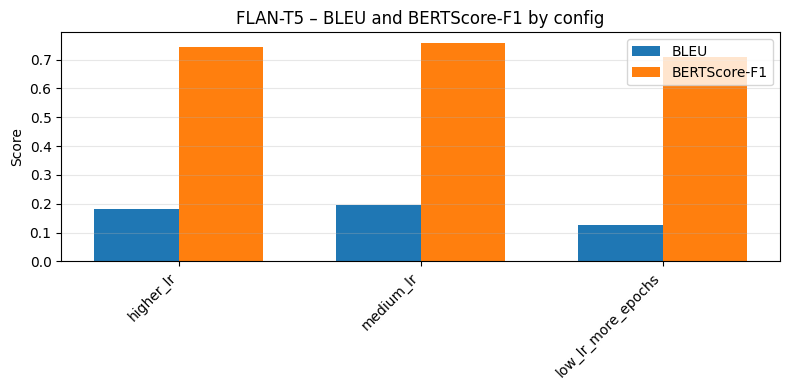

In [39]:
cfg_names_flan = [r['config']['name'] for r in results_flan]
bleu_scores_flan = [r['bleu'] for r in results_flan]
bert_f1_flan = [r['bertscore_f1'] for r in results_flan]

x = np.arange(len(cfg_names_flan))
width = 0.35

plt.figure(figsize=(8, 4))
plt.bar(x - width/2, bleu_scores_flan, width, label='BLEU')
plt.bar(x + width/2, bert_f1_flan, width, label='BERTScore-F1')

plt.xticks(x, cfg_names_flan, rotation=45, ha='right')
plt.ylabel('Score')
plt.title('FLAN-T5 – BLEU and BERTScore-F1 by config')
plt.grid(axis='y', alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

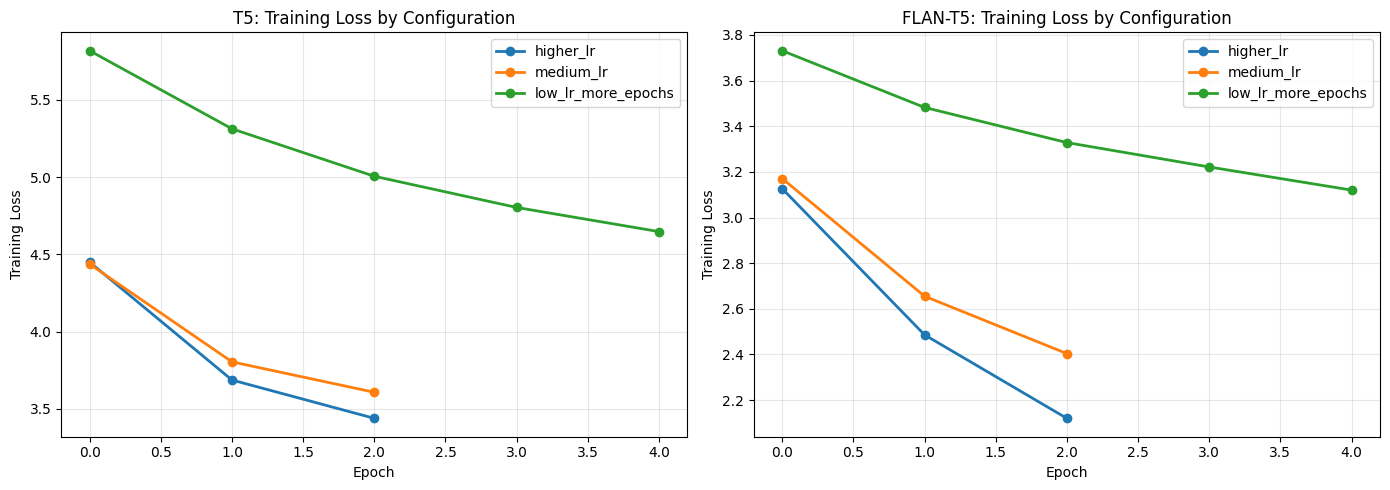

In [40]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# T5 Loss Curves
for result in results_t5:
    history = result['history']
    cfg_name = result['config']['name']
    axes[0].plot(history['train_loss'], marker='o', label=cfg_name, linewidth=2)

axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Training Loss')
axes[0].set_title('T5: Training Loss by Configuration')
axes[0].legend()
axes[0].grid(alpha=0.3)

# FLAN-T5 Loss Curves
for result in results_flan:
    history = result['history']
    cfg_name = result['config']['name']
    axes[1].plot(history['train_loss'], marker='o', label=cfg_name, linewidth=2)

axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Training Loss')
axes[1].set_title('FLAN-T5: Training Loss by Configuration')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

In [41]:
all_results = []

for r in results_t5:
    all_results.append({
        'Model': 'T5',
        'Config': r['config']['name'],
        'BLEU': r['bleu'],
        'BERTScore-F1': r['bertscore_f1']
    })

for r in results_flan:
    all_results.append({
        'Model': 'FLAN-T5',
        'Config': r['config']['name'],
        'BLEU': r['bleu'],
        'BERTScore-F1': r['bertscore_f1']
    })

all_results_df = pd.DataFrame(all_results)
print("T5 vs FLAN-T5 – final comparison:")
print(all_results_df.to_string(index=False))

T5 vs FLAN-T5 – final comparison:
  Model             Config     BLEU  BERTScore-F1
     T5          higher_lr 0.015169      0.620309
     T5          medium_lr 0.021236      0.518438
     T5 low_lr_more_epochs 0.034950      0.388157
FLAN-T5          higher_lr 0.181349      0.743602
FLAN-T5          medium_lr 0.194813      0.756843
FLAN-T5 low_lr_more_epochs 0.126926      0.710230


In [42]:
best_t5 = max([r for r in all_results if r['Model'] == 'T5'], key=lambda x: x['BERTScore-F1'])
best_flan = max([r for r in all_results if r['Model'] == 'FLAN-T5'], key=lambda x: x['BERTScore-F1'])

compare_best = pd.DataFrame([best_t5, best_flan])
print("\nBest configs per model:")
print(compare_best.to_string(index=False))


Best configs per model:
  Model    Config     BLEU  BERTScore-F1
     T5 higher_lr 0.015169      0.620309
FLAN-T5 medium_lr 0.194813      0.756843
